In [0]:
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.models import Model
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.merge import concatenate
from keras.layers import Flatten
import keras.backend as K

from keras.applications import DenseNet121

In [0]:
class Encoder():
    def __init__(self ,input_dim=(256,256,3) , model_type='densenet_121' , weights= "imagenet" ):
        self.input_dim=input_dim
        self.model_type = model_type
        self.weights=weights
        self.model = self.make_model()

    def make_model(self):
        """
        This model is responsible for building a keras model

        :return:
            keras model:
        """
        if self.model_type=='densenet_121':
            model = self.make_densenet_121(self.weights)


        return model

    def make_densenet_121(self,weights):
        model = DenseNet121(
            include_top=False,
            weights=weights,
            input_tensor=None,
            input_shape=self.input_dim,
            pooling=None,
            classes=1000,
        )

        return model

In [0]:
Base_encoder = Encoder().model
Seg_encoder = Encoder().model
Det_encoder = Encoder().model

Base_encoder = Model(inputs = [Base_encoder.get_input_at(0)], outputs= [Base_encoder.layers[-3].output], name="Encoder_model")
Seg_encoder = Model(inputs = [Seg_encoder.get_input_at(0)], outputs= [Seg_encoder.layers[-3].output], name="Segmentation_model")
Det_encoder = Model(inputs = [Det_encoder.get_input_at(0)], outputs= [Det_encoder.layers[-3].output], name="Detection_model")

In [0]:
Base_encoder.inputs

[<tf.Tensor 'input_8:0' shape=(None, 256, 256, 3) dtype=float32>]

In [0]:
def UDenseNet_v1(encoder, input_shape=(256,256,1)):
    '''
    Paper review
    https://www.mdpi.com/2072-4292/11/21/2499
    '''
    skip_layers = [308,136,48]
    dense_block_4 = 426
    
    inputs = encoder.input
    #output of last Dense Block 3 (DB x16)
    conv5 = encoder.layers[-1].output #(8,8,1024)
    print(conv5)
    #start TU
    uconv5 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same')(conv5)
    uconv5 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same')(uconv5)
    tu5 = Conv2DTranspose(256, (3, 3), strides = (2, 2), padding = 'same')(uconv5)#(16,16,)
    #skip dense block 3 (DB x24)
    conv4 = encoder.layers[skip_layers[0]].output
    print(conv4)
    c5 = concatenate([conv4,tu5], axis=3)
    
    #start TU
    uconv6 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same')(c5)
    uconv6 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same')(uconv6)
    tu6 = Conv2DTranspose(256, (3, 3), strides = (2, 2), padding = 'same')(uconv6)#(32,32,)
    #skip dense block 2 (DB x12)
    conv3 = encoder.layers[skip_layers[1]].output
    print(conv3)
    c6 = concatenate([conv3,tu6], axis=3)
    
    #start TU
    uconv7 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same')(c6)
    uconv7 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same')(uconv7)
    tu7 = Conv2DTranspose(256, (3, 3), strides = (2, 2), padding = 'same')(uconv7)#(64,64,)
    #skip dense block 1 (DB x6)
    conv2 = encoder.layers[skip_layers[2]].output
    print(conv2)
    c7 = concatenate([conv2,tu7], axis=3)#(64,64)
    #start TU
    uconv8 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same')(c7)
    tu8 = Conv2DTranspose(256, (3, 3), strides = (2, 2), padding = 'same')(uconv8)#(128,128,)
    #start TU
    uconv9 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same')(tu8)
    tu9 = Conv2DTranspose(3, (3, 3), strides = (2, 2), padding = 'same')(uconv9)#(256,256,)
    
    model = Model(inputs,tu9)
    model.name = 'UDenseNet'
    return model
    

In [0]:
Enc_seg_model = UDenseNet_v1(Seg_encoder) # Encoder + Seg  (input 256,256,3)(output 256,256,3)

for layer in Enc_seg_model.layers:
    layer.name = layer.name + str('_S')

Tensor("conv5_block16_concat_7/concat:0", shape=(None, 8, 8, 1024), dtype=float32)
Tensor("conv4_block24_concat_7/concat:0", shape=(None, 16, 16, 1024), dtype=float32)
Tensor("conv3_block12_concat_7/concat:0", shape=(None, 32, 32, 512), dtype=float32)
Tensor("conv2_block6_concat_7/concat:0", shape=(None, 64, 64, 256), dtype=float32)


In [0]:
Enc_seg_model.output

<tf.Tensor 'conv2d_transpose_14/BiasAdd:0' shape=(None, None, None, 3) dtype=float32>

In [0]:
Enc_seg_model.summary()

Model: "UDenseNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9_S (InputLayer)          (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_15_S (ZeroPaddin (None, 262, 262, 3)  0           input_9_S[0][0]                  
__________________________________________________________________________________________________
conv1/conv_S (Conv2D)           (None, 128, 128, 64) 9408        zero_padding2d_15_S[0][0]        
__________________________________________________________________________________________________
conv1/bn_S (BatchNormalization) (None, 128, 128, 64) 256         conv1/conv_S[0][0]               
__________________________________________________________________________________________

In [0]:
from keras.layers import Input,GlobalAveragePooling2D, Flatten,Conv2D,Concatenate
from keras.activations import relu, softmax
from keras.models import Model
from keras.layers import BatchNormalization
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,Activation
from keras.applications import  VGG16

def StdConv(kernel_size,stride_size,n_output):    
    def f(input):
        x = Conv2D(kernel_size=kernel_size, filters=n_output, strides=stride_size, padding='same')(input)
        x = Activation(relu)(x)
        x = BatchNormalization()(x)
        x = Dropout(0.25)(x)   

        return x
    
    return f
    
def SSD_Model(encoder):
    net = VGG16(include_top=False, weights='imagenet', input_shape=(32,32,3))

    encoder_out= encoder.layers[-1].output
    skip_layers = [308,136,48]

    uconv5 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(encoder_out)
    uconv5 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(uconv5)
    tu5 = Conv2DTranspose(128, (3, 3), strides = (2, 2), padding = 'same')(uconv5)#(16,16,)
    #skip dense block 3 (DB x24)
    conv4 = encoder.layers[skip_layers[0]].output
    print(conv4)
    c5 = concatenate([conv4,tu5], axis=3)
    
    #start TU
    uconv6 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(c5)
    uconv6 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(uconv6)
    tu6 = Conv2DTranspose(3, (3, 3), strides = (2, 2), padding = 'same')(uconv6)#(32,32,)
      
    x = net(tu6)
    x = Activation(relu)(x)
    x = Dropout(0.25,name='VGG_backbone')(x)   
       
    x = StdConv(kernel_size=3,stride_size=1,n_output=256)(x) #[7*7*256]
    x = StdConv(kernel_size=3,stride_size=2,n_output=128)(x) #[4*4*128]
    
    # (2) Box regression Branch
    x2 = Conv2D(kernel_size=3, filters=4, strides=1, padding='same')(x)
    #x2 = Flatten()(x2)
    x2 = Dense(4)(x2)
    x2 = Activation('linear',name='regression')(x2)
    
    # Then, we concatenate the 2 branch together
    
        
    model = Model(inputs=encoder.input, outputs=x2)
    model.name = 'Detection_Model'
    return model

In [0]:
det= SSD_Model(Det_encoder)
for layer in det.layers:
    layer.name = layer.name + str('_D')

Tensor("conv4_block24_concat_8/concat:0", shape=(None, 16, 16, 1024), dtype=float32)


In [0]:
det.output

<tf.Tensor 'regression_1/Identity:0' shape=(None, 1, 1, 4) dtype=float32>

In [0]:
merged_model = Model([Enc_seg_model.input, det.input], [Enc_seg_model.output, det.output])

In [0]:
inputs = Base_encoder.input
#output of last Dense Block 3 (DB x16)
conv5 = Base_encoder.layers[-1].output #(8,8,1024)
print(conv5)
#start TU
uconv5 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same')(conv5)
uconv5 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same')(uconv5)
tu5 = Conv2DTranspose(3, (3, 3), strides = (2, 2), padding = 'same')(uconv5)#(16,16,)

Base_encoder = Model(inputs = inputs , outputs = tu5)

Tensor("conv2d_transpose_17/BiasAdd:0", shape=(None, None, None, 3), dtype=float32)


In [0]:
Base_encoder.output

<tf.Tensor 'conv2d_transpose_20/BiasAdd:0' shape=(None, None, None, 3) dtype=float32>

In [0]:
encoder_out= Base_encoder.layers[-1].output
out = merged_model([encoder_out, encoder_out])

BIG_BANG_MODEL = Model(inputs = Base_encoder.input, outputs = out)

In [0]:
BIG_BANG_MODEL.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_13 (ZeroPadding2 (None, 262, 262, 3)  0           input_8[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 128, 128, 64) 9408        zero_padding2d_13[0][0]          
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1/conv[0][0]                 
___________________________________________________________________________________________

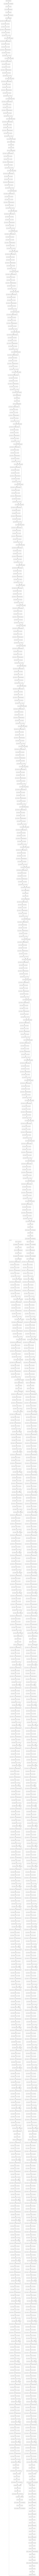

In [0]:
from keras.utils import plot_model
plot_model(BIG_BANG_MODEL,
           show_layer_names=True,
           rankdir="TB",
           expand_nested=True,
           to_file='model.png')

In [0]:
BIG_BANG_MODEL.compile(optimizer=Adam(),loss=['mean_absolute_error', 'mean_absolute_error'], metrics=['accuracy'])

In [0]:
BIG_BANG_MODEL.output

[<tf.Tensor 'model_10/conv2d_transpose_14_S/BiasAdd:0' shape=(None, None, None, 3) dtype=float32>,
 <tf.Tensor 'model_10/dense_2_D/BiasAdd:0' shape=(None, 0, 0, 4) dtype=float32>]

In [0]:
import cv2
x=cv2.imread('122.jpg')
x= cv2.resize(x, (256,256))

In [0]:
y = [np.expand_dims(np.array(x),0), np.reshape(np.array([1,2,4,3]), (1,4))]

In [0]:
BIG_BANG_MODEL.fit(np.expand_dims(x,0),y)